# 🤔 Active learning with ModAL and scikit-learn

In this tutorial, we will walk through the process of building an active learning prototype with *Rubrix*, the active learning framework [ModAL](https://modal-python.github.io/) and [scikit-learn](https://scikit-learn.org/)

![screenshot of the status filter in the Rubrix UI](https://github.com/recognai/rubrix-materials/raw/main/tutorials/modal/modal1.png "Filtering for the 'Default' status let's you display only examples that were not annotated yet.")

## Introduction

**Our goal is to show you how to incorporate Rubrix into interactive workflows involving a human in the loop**. This is only a proof of concept for educational purposes and to inspire you with some ideas involving interactive learning processes, and how they can help to quickly build a training data set from scratch. There are several great tools which focus on active learning, being [Prodi.gy](https://prodi.gy/) the most prominent.

### What is active learning?

> *Active learning is a special case of machine learning in which a learning algorithm can interactively query a user (or some other information source) to label new data points with the desired outputs. In statistics literature, it is sometimes also called optimal experimental design. The information source is also called teacher or oracle.* [[Wikipedia]](https://en.wikipedia.org/wiki/Active_learning_(machine_learning))

### This tutorial

In this tutorial, we will build a simple text classifier by combining scikit-learn, ModAL and *Rubrix*.
Scitkit-learn will provide the model that we embed in an active learner from ModAL, and you and *Rubrix* will serve as the information source that teach the model to become a sample efficient classifier.


The tutorial is organized into:

1. **Loading the data**: Quick look at the data

2. **Create the active learner**: Create the model and embed it in the active learner

3. **Active learning loop**: Annotate samples and teach the model

But first things first, let's install our extra dependencies and setup *Rubrix*.

## Setup Rubrix

**If you are new to Rubrix, visit and ⭐ star Rubrix for more materials like and detailed docs**: [Github repo](https://github.com/recognai/rubrix)

If you have not installed and launched Rubrix, check the [Setup and Installation guide](https://docs.rubrix.ml/en/latest/getting_started/setup%26installation.html).


Once installed, you only need to import Rubrix:

In [1]:
import rubrix as rb

## Setup 

### Install scikit-learn and ModAL

Apart from the two required dependencies we will also install matplotlib to plot our improvement for each active learning loop. However, this is of course optional and you can simply ignore this dependency.

In [3]:
!pip install modAL scikit-learn matplotlib -qqq
exit(0)

### Imports

Let us import all the necessary stuff in the beginning.

In [2]:
import rubrix as rb
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.exceptions import NotFittedError
from modAL.models import ActiveLearner
import matplotlib.pyplot as plt

## 1. Loading and preparing data

*Rubrix* allows you to log and track data for different NLP tasks (such as `Token Classification` or `Text Classification`). 

In this tutorial, we will use the [YouTube Spam Collection](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) data set which is a binary classification task for detecting spam comments in YouTube videos.
Let's load the data and have a look at it.

In [3]:
train_df = pd.read_csv("data/active_learning/train.csv")
test_df = pd.read_csv("data/active_learning/test.csv")

In [4]:
test_df

COMMENT_ID  \
0            z120djlhizeksdulo23mj5z52vjmxlhrk04   
1              z133ibkihkmaj3bfq22rilaxmp2yt54nb   
2          z12gxdortqzwhhqas04cfjrwituzghb5tvk0k   
3    _2viQ_Qnc6_ZYkMn1fS805Z6oy8ImeO6pSjMLAlwYfM   
4          z120s1agtmmetler404cifqbxzvdx15idtw0k   
..                                           ...   
387        z13pup2w2k3rz1lxl04cf1a5qzavgvv51vg0k   
388          z13psdarpuzbjp1hh04cjfwgzonextlhf1w   
389        z131xnwierifxxkj204cgvjxyo3oydb42r40k   
390          z12pwrxj0kfrwnxye04cjxtqntycd1yia44   
391          z13oxvzqrzvyit00322jwtjo2tzqylhof04   

                              AUTHOR                        DATE  \
0               Murlock Nightcrawler  2015-05-24T07:04:29.844000   
1    Debora Favacho (Debora Sparkle)  2015-05-21T14:08:41.338000   
2               Muhammad Asim Mansha                         NaN   
3                        mile panika  2013-11-03T14:39:42.248000   
4                     Sheila Cenabre         2014-08-19T12:33:11   
..                               ...                         ...   
387                  geraldine lopez  2015-05-20T23:44:25.920000   
388                       bilal bilo  2015-05-22T20:36:36.926000   
389                    YULIOR ZAMORA         2014-09-10T01:35:54   
390                      ‫ארז אריה‬‎  2015-05-15T19:46:53.719000   
391                        Octavia W  2015-05-22T02:33:26.041000   

                                               CONTENT  CLASS  VIDEO  
0                                  Charlie from LOST?﻿      0      3  
1                          BEST SONG EVER X3333333333﻿      0      4  
2                       Aslamu Lykum... From Pakistan﻿      1      3  
3    I absolutely adore watching football plus I’ve...      1      4  
4    I really love this video.. http://www.bubblews...      1      1  
..                                                 ...    ...    ...  
387                         love the you lie the good﻿      0      3  
388                                     I liked<br />﻿      0      4  
389  I    loved        it           so       much  ...      0      1  
390                                        good party﻿      0      2  
391                                        Waka waka ﻿      0      4  

[392 rows x 6 columns]

As we can see the data contains the comment id, the author of the comment, the date, the content (the comment itself) and a class column that indicates if a comment is spam or ham.
We will use the class column only in the test data set to illustrate the effectiveness of the active learning approach with *Rubrix*.
For the training data set we simply ignore the column and assume that we are gathering training data from scratch.

## 2. Defining our classifier and Active Learner

For this tutorial we will use a multinomial Naive Bayes classifier that is suitable for classification with discrete features (e.g., word counts for text classification).

In [5]:
# Define our classification model
classifier = MultinomialNB()

Then we define our active learner that uses the classifier as an estimator of the most uncertain predictions.

In [6]:
# Define active learner
learner = ActiveLearner(
    estimator=classifier,
)

The features for our classifier will be the counts of different word [n-grams](https://en.wikipedia.org/wiki/N-gram).
That is, for each example we count the number of contiguous sequences of *n* words, where n goes from 1 to 5.

The output of this operation will be matrices of n-gram counts for our train and test data set, where each element in a row equals the counts of a specific word n-gram found in the example.

In [7]:
# The resulting matrices will have the shape of (`nr of examples`, `nr of word n-grams`)
vectorizer = CountVectorizer(ngram_range=(1, 5))

X_train = vectorizer.fit_transform(train_df.CONTENT)
X_test = vectorizer.transform(test_df.CONTENT)

## 3. Active Learning loop

Now we can start our active learning loop that consists of iterating over following steps:

1. Annotate samples
2. Teach the active learner
3. Plot the improvement (optional)

Before starting the learning loop, let us define two variables:

- the number of instances we want to annotate per iteration
- and a variable to keep track of our improvements by recording the achieved accuracy after each iteration


In [8]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

### 1. Annotate samples

The first step of the training loop is about annotating *n* examples that have the most uncertain prediction.
In the first iteration these will be just random examples, since the classifier is still not trained and we do not have predictions yet.

In [9]:
# query examples from our training pool with the most uncertain prediction
query_idx, query_inst = learner.query(X_train, n_instances=n_instances)

# get predictions for the queried examples
try:
    probs = learner.predict_proba(X_train[query_idx])
# For the very first query we do not have any predictions
except NotFittedError:
    probs = [[0.5, 0.5]]*n_instances

# Build the Rubrix records
records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs=train_df.CONTENT.iloc[idx],
        prediction=list(zip(["HAM", "SPAM"], [0.5, 0.5])),
        prediction_agent="MultinomialNB",
    )
    for idx in query_idx
]

# Log the records
rb.log(records, name="active_learning_tutorial")

BulkResponse(dataset='active_learning_tutorial', processed=10, failed=0)

After logging the records to *Rubrix* we switch over to the UI where we can find the newly logged examples in the `active_learning_tutorial` dataset.
To only show the examples that are still missing an annotation, you can select "Default" in the *Status* filter as shown in the screenshot below.
After annotating a few examples you can press the *Refresh* button in the upper right corner to update the view with respect to the filters.

![screenshot of the status filter in the Rubrix UI](https://github.com/recognai/rubrix-materials/raw/main/tutorials/modal/modal1.png "Filtering for the 'Default' status let's you display only examples that were not annotated yet.")

Once you are done annotating the examples, you can continue with the active learning loop.

### 2. Teach the learner

The second step in the loop is to teach the learner.
Once we trained our classifier with the newly annotated examples, we will apply the classifier to the test data and record the accuracy to keep track of our improvement.

In [ ]:
# Load the annotated records into a pandas DataFrame
records_df = rb.load("active_learning_tutorial")

# filter examples from the last annotation session
idx = records_df.id.isin(query_idx)

# check if all examples were annotated
if any(records_df[idx].annotation.isna()):
    raise UserWarning("Please annotate first all your samples before teaching the model")

# train the classifier with the newly annotated examples
y_train = records_df[idx].annotation.map(lambda x: int(x[0] == "SPAM"))
learner.teach(X=X_train[query_idx], y=y_train.to_list())
    
# Keep track of our improvement
accuracies.append(learner.score(X=X_test, y=test_df.CLASS))

Now go back to step 1 and repeat both steps a couple of times.

### 3. Plot the improvement (optional)

After a few iterations we can check the current performance of our classifier by plotting the accuracies.
If you think the performance can still be improved you can repeat step 1 and 2 and check the accuracy again.

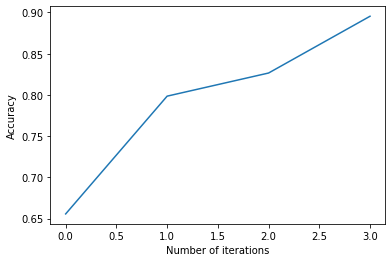

In [39]:
# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");

## Summary

In this tutorial we saw how to embed *Rubrix* in an active learning loop and how it can help you to gather a sample efficient data set by annotating only the most decisive examples.
Here we created a rather minimalist active learning loop, but *Rubrix* does not really care about the complexity of the loop.
It will always help you to record and annotate data examples with their model predictions, allowing you to quickly build up a data set from scratch. 

## Next steps

### 📚 [Rubrix documentation](https://docs.rubrix.ml) for more guides and tutorials.

### 🙋‍♀️ Join the Rubrix community! A good place to start is the [discussion forum](https://github.com/recognai/rubrix/discussions).

### ⭐ Rubrix [Github repo](https://github.com/recognai/rubrix) to stay updated.

## Appendix: Compare query strategies, random vs max uncertainty

In this appendix we quickly demonstrate the effectiveness of annotating only the most uncertain predictions compared to random annotations.
So the next time you want to build a data set from scratch, keep this strategy in mind and maybe use *Rubrix* for the annotation process 😀.

In [ ]:
import numpy as np

n_iterations = 150
n_instances = 10
random_samples = 50


# max uncertainty strategy
accuracies_max = []
for i in range(random_samples):
    train_rnd_df = train_df#.sample(frac=1)
    test_rnd_df = test_df#.sample(frac=1)
    X_rnd_train = vectorizer.transform(train_rnd_df.CONTENT)
    X_rnd_test = vectorizer.transform(test_rnd_df.CONTENT)
    
    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())

    for i in range(n_iterations):
        query_idx, _ = learner.query(X_rnd_train, n_instances=n_instances)
        learner.teach(X=X_rnd_train[query_idx], y=train_rnd_df.CLASS.iloc[query_idx].to_list())
        accuracies.append(learner.score(X=X_rnd_test, y=test_rnd_df.CLASS))
    accuracies_max.append(accuracies)

# random strategy
accuracies_rnd = []
for i in range(random_samples):
    accuracies, learner = [], ActiveLearner(estimator=MultinomialNB())
    
    for random_idx in np.random.choice(X_train.shape[0], size=(n_iterations, n_instances), replace=False):    
        learner.teach(X=X_train[random_idx], y=train_df.CLASS.iloc[random_idx].to_list())
        accuracies.append(learner.score(X=X_test, y=test_df.CLASS))
    accuracies_rnd.append(accuracies)
    
arr_max, arr_rnd = np.array(accuracies_max), np.array(accuracies_rnd)

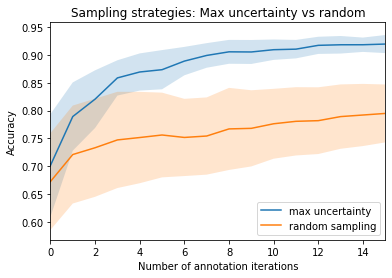

In [ ]:
plt.plot(range(n_iterations), arr_max.mean(0))
plt.fill_between(range(n_iterations), arr_max.mean(0)-arr_max.std(0), arr_max.mean(0)+arr_max.std(0), alpha=0.2)
plt.plot(range(n_iterations), arr_rnd.mean(0))
plt.fill_between(range(n_iterations), arr_rnd.mean(0)-arr_rnd.std(0), arr_rnd.mean(0)+arr_rnd.std(0), alpha=0.2)
      
plt.xlim(0,15)
plt.title("Sampling strategies: Max uncertainty vs random")
plt.xlabel("Number of annotation iterations")
plt.ylabel("Accuracy")
plt.legend(["max uncertainty", "random sampling"], loc=4)

## Appendix: How did we obtain the train/test data?

In [ ]:
import pandas as pd
from urllib import request
from sklearn.model_selection import train_test_split
from pathlib import Path
from tempfile import TemporaryDirectory


def load_data() -> pd.DataFrame:
    """
    Downloads the [YouTube Spam Collection](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/)
    and returns the data as a tuple with a train and test DataFrame.
    """
    links, data_df = [
        "http://lasid.sor.ufscar.br/labeling/datasets/9/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/10/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/11/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/12/download/",
        "http://lasid.sor.ufscar.br/labeling/datasets/13/download/",
    ], None
    
    with TemporaryDirectory() as tmpdirname:
        dfs = []
        for i, link in enumerate(links):
            file = Path(tmpdirname) / f"{i}.csv"
            request.urlretrieve(link, file)
            df = pd.read_csv(file)
            df["VIDEO"] = i
            dfs.append(df)
        data_df = pd.concat(dfs).reset_index(drop=True)
        
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
    
    return train_df, test_df

train_df, test_df = load_data()
train_df.to_csv("data/active_learning/train.csv", index=False)
test_df.to_csv("data/active_learning/test.csv", index=False)